# [TRL - Transformer Reinforcement Learning](https://huggingface.co/docs/trl/index)
- `Supervised Fine-tuning, (SFT)`, `Reward Modeling, (RM)`, `the Proximal Policy Optimization, (PPO)` 까지 제공할 수 있는 Transformer 언어 모델 학습용 라이브러리

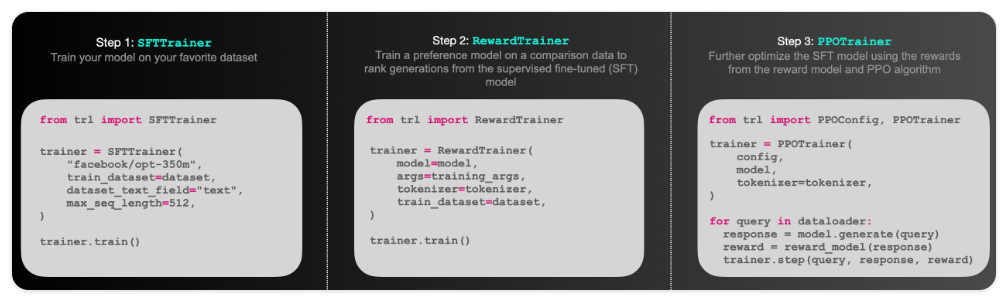

## Trainer vs SFTTrainer
LLM 파인튜닝을 위해 `TRL 라이브러리`의 `Trainer 클래스` 또는 `SFTTrainer 클래스`를 많이 이용하는 추세입니다. 두 가지 클래스의 장점 및 차이점은 다음과 같습니다.

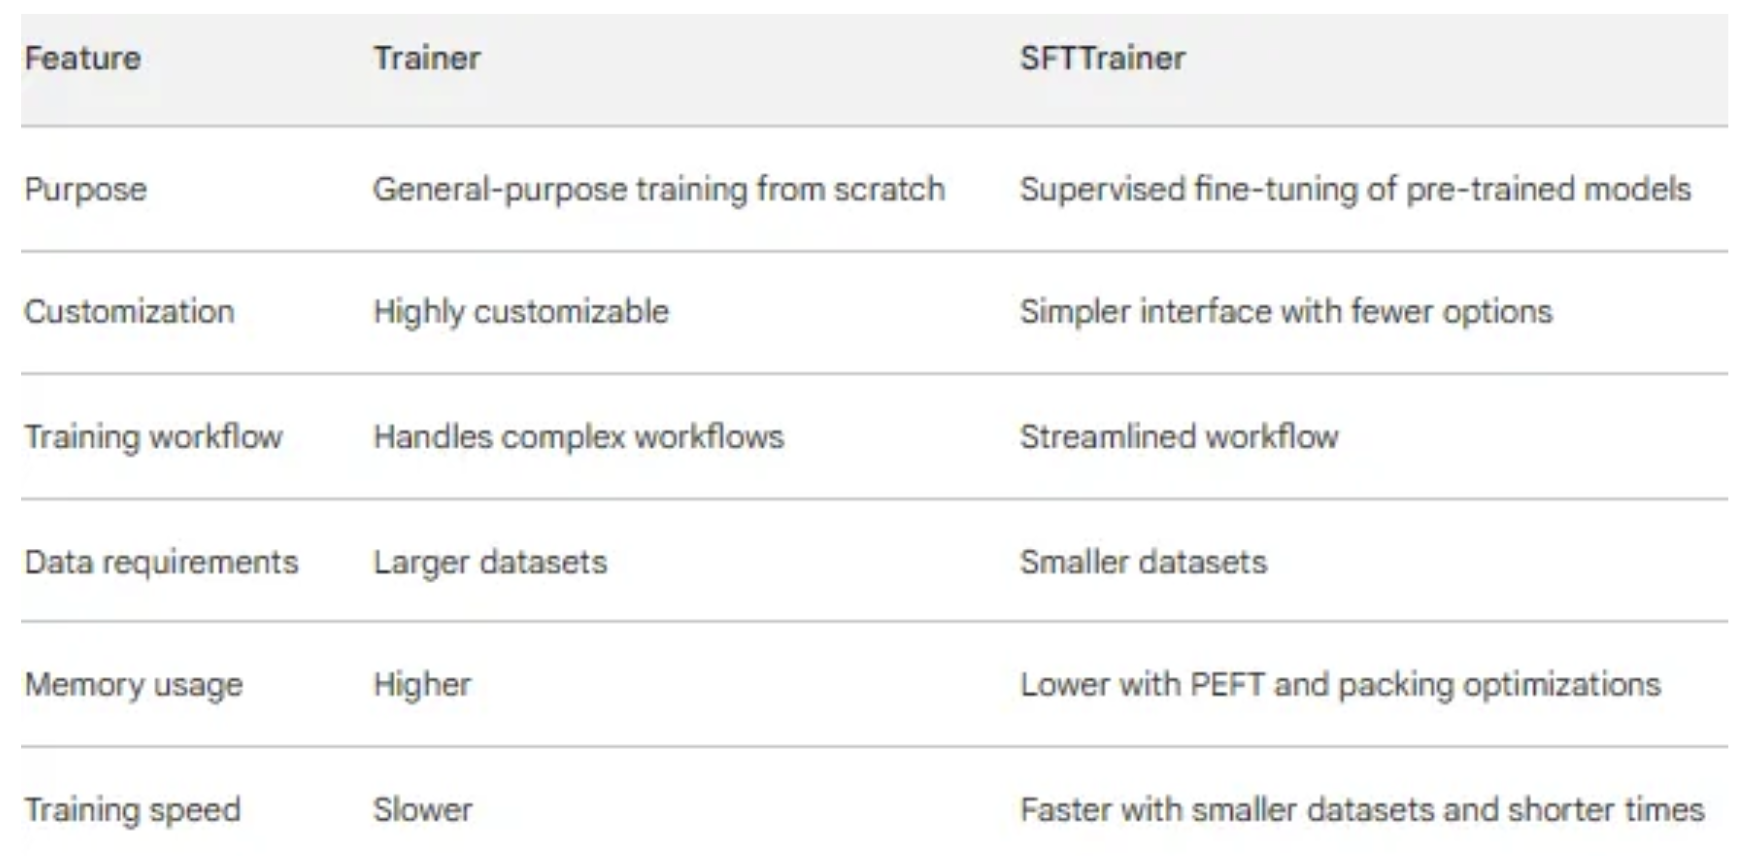

### Trainer

- `일반적인 목적의 학습`: 텍스트 분류, QA, 요약과 같은 지도 학습에 대해 처음부터 모델을 학습하도록 설계됨
- `고도화된 커스터마이징`: hyperparameters, optimizers, schedulers, logging, 평가 지표를 파인튜닝하기 위한 광범위한 config 옵션 제공
- `복잡한 학습 워크플로우 처리`: gradient accumulation, early stopping, checkpointing, 분산학습 등 기능 지원
- `더 많은 데이터 필요`: 일반적으로 처음부터 효과적인 학습을 위해 더 큰 데이터셋 필요

### SFTTrainer

- `Supervised Fine-tuning (SFT)`: 지도 학습 작업에서 더 작은 데이터 세트로 사전 학습된 모델을 미세 조정하는 데 최적화
- `간단한 인터페이스`: 더 적은 구성 옵션으로 간소화된 워크플로우를 제공하여 보다 쉽게 시작할 수 있음
- `효율적인 메모리 사용`:
PEFT(parameter-efficient) 및 패킹 최적화(packing optimization)와 같은 기술을 사용하여 학습 중 메모리 소비를 줄임
- `더 빠른 학습`: Trainer 보다 더 작은 데이터셋과 더 짧은 학습 시간으로 더 나은 정확도 달성

### 요약
- `Trainer 사용`: 데이터 세트가 크고 학습 loop 또는 복잡한 학습 워크플로우에 대한 광범위한 사용자 정의가 필요한 경우.
- `SFTTrainer 사용`: 사전 학습된 모델과 상대적으로 작은 데이터셋이 있고 효율적인 메모리 사용으로 더 간단하고 빠른 파인튜닝을 원하는 경우.

## [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer)
- SFT를 위한 Trainer를 제공합니다.
- 해당 Trainer는 기존 huggingface에서 사용하던 trainer와 크게 다르지 않습니다.

아래는 가장 기초적인 호출 방법으로 기존의 Trainer에서 쉽게 보던 모습입니다.
- 모델을 직접 불러와 Trainer에게 넘겨주어도 되고 아래처럼 huggingface에 업로드된 경로 혹은 로컬의 path를 넘겨주면 해당 경로에 있는 모델과 토크나이저를 자동으로 모델이 불러올 수 있게 됩니다.

```python
from datasets import load_dataset
from trl import SFTTrainer

# 학습할 데이터셋 생성
dataset = load_dataset("imdb", split="train")

# SFT 생성
trainer = SFTTrainer(
    model="facebook/opt-350m", # LLM
    train_dataset=dataset, # 학습할 데이터셋
    dataset_text_field="text", # 데이터셋의 컬럼명
    max_seq_length=512, # 최대 문장길이
)

# SFT 학습 시작
trainer.train()

```

### With PEFT
- TRL에 좋은점은 PEFT를 사용할 수 있게 설계되어 있다는데 있습니다.
- 이 부분이 Finetuning에서 크게 시간을 단축할 수 있는 LoRA를 쉽게 사용할 수 있도록 되어 있습니다.

아래와 같이 peft를 불러와 LoraConfig만 작성하여 SFTTrainer에 넘겨주면 됩니다.

```python
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig

# 학습 데이터셋
dataset = load_dataset("imdb", split="train")

# PEFT 설정
# -> 최소한의 메모리를 이용해서 학습할 수 있게 하는 최적화 방법
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

trainer = SFTTrainer(
    "EleutherAI/gpt-neo-125m",
    train_dataset=dataset,
    dataset_text_field="text",
    peft_config=peft_config # PEFT 적용
)

trainer.train()

```

- 여기에 더해 대형 자연어 모델을 불러오기 위한 방법도 적용이 가능합니다.
- 이 방법에서는 Trainer밖에서 모델을 불러오고 Trainer에게 넘겨주어야만 합니다.
- `load_in_8bit` or `load_in_4bit`옵션을 통해 불러오면 되겠습니다.

```python
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

# 외부에서 모델 생성
model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/gpt-neo-125m",
    load_in_8bit=True, # 옵션
    device_map="auto",
)

trainer = SFTTrainer(
    model,
    train_dataset=dataset,
    dataset_text_field="text",
    peft_config=peft_config,
)

trainer.train()
```


# SFTTrainer 예제

In [ ]:
!pip install typing_extensions==4.7.1 --upgrade
!pip install trl==0.9.6 peft==0.17.1 wandb # Trying a different version

  Using cached typing_extensions-4.7.1-py3-none-any.whl.metadata (3.1 kB)
Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.13.0
    Uninstalling typing_extensions-4.13.0:
      Successfully uninstalled typing_extensions-4.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires typing-extensions>=4.10.0, but you have typing-extensions 4.7.1 which is incompatible.
openai 1.68.2 requires typing-extensions<5,>=4.11, but you have typing-extensions 4.7.1 which is incompatible.
pydantic 2.10.6 requires typing-extensions>=4.12.2, but you have typing-extensions 4.7.1 which is incompatible.
google-genai 1.7.0 requires typing-extensions<5.0.0,>=4.11.0, but you have typing-extensions 4.7.1 which is incompatible.
typeguard 4.4.2 requires typing

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

## [LLM - LGAI-EXAONE](https://huggingface.co/LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct)

In [3]:
model_id = 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/70.7k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

## [datset](https://huggingface.co/datasets/CarrotAI/ko-instruction-dataset)

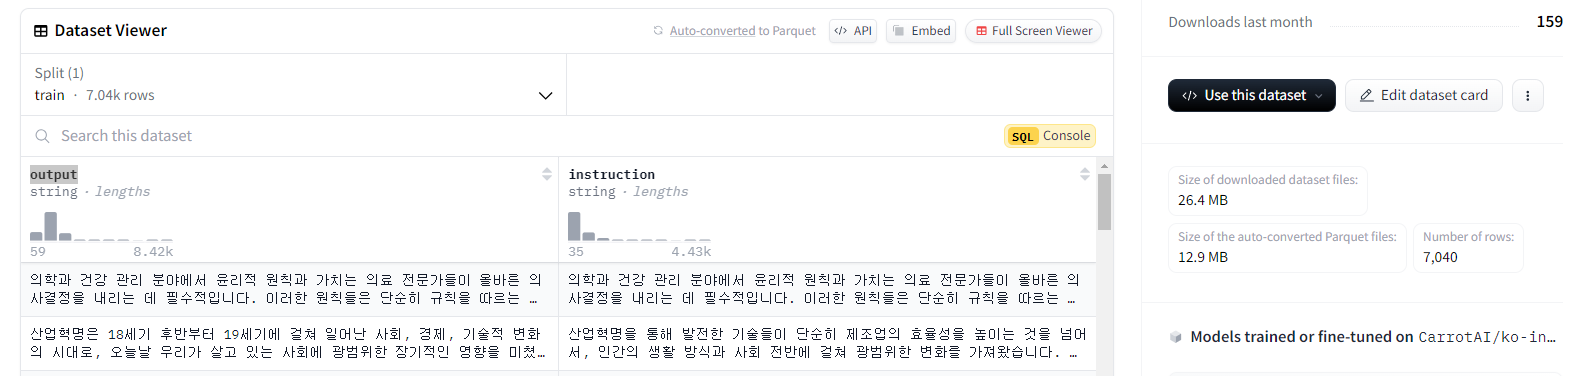

In [4]:
dataset = load_dataset("CarrotAI/ko-instruction-dataset", split = "train")
len(dataset)

README.md:   0%|          | 0.00/629 [00:00<?, ?B/s]

instruction_korean.json:   0%|          | 0.00/26.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7040 [00:00<?, ? examples/s]

7040

In [5]:
dataset[0]

{'output': "의학과 건강 관리 분야에서 윤리적 원칙과 가치는 의료 전문가들이 올바른 의사결정을 내리는 데 필수적입니다. 이러한 원칙들은 단순히 규칙을 따르는 것 이상의 의미를 가지며, 복잡한 의료 상황에서 발생할 수 있는 윤리적 딜레마를 해결하는 데 중요한 역할을 합니다. 이를 위해, 다음과 같이 몇 가지 윤리 원칙과 가치를 명시하고, 이를 실제 사례에 어떻게 적용할 수 있는지를 논의해 보겠습니다.\n\n1. 자율성(Autonomy): 환자는 자신의 건강에 대한 결정을 스스로 내릴 권리가 있습니다. 이는 환자가 정보에 기반하여 자발적으로 동의하거나 거부할 수 있는 권리를 포함합니다.\n\n2. 비이해(Nonmaleficence): 의료 전문가는 먼저, 환자에게 해를 끼치지 않는 것을 약속해야 합니다. 이는 '먼저 해를 주지 않는다'는  hippocratic oath의 기본 원칙입니다.\n\n3. 이익(Beneficence): 의료 전문가는 환자의 복지를 증진시키기 위해 노력해야 합니다. 이는 환자에게 최선의 치료와 관리를 제공하는 것을 의미합니다.\n\n4. 정의(Justice): 모든 환자에게 공정하게 치료와 자원을 제공해야 합니다. 이는 사회적, 경제적, 인종적 배경과 관계없이 의료 서비스에 대한 접근성을 보장하는 것을 포함합니다.\n\n이제 이러한 원칙들을 적용하는 몇 가지 시나리오를 살펴보겠습니다.\n\n- 자율성의 적용: 환자가 특정 치료를 거부하는 경우, 의료 전문가는 환자에게 충분한 정보를 제공하고, 그들의 결정을 존중해야 합니다. 예를 들어, 암 환자가 추가적인 화학요법을 거부하는 경우, 의사는 환자의 결정을 존중하고, 그 결정이 정보에 기반한 것인지 확인해야 합니다.\n\n- 비이해와 이익의 균형: 특정 치료가 환자에게 미세한 이점을 제공할 수 있지만, 동시에 부작용의 위험도 존재하는 경우, 의료 전문가는 이 두 가지 원칙 사이의 균형을 맞추어야 합니다. 예를 들어, 약물의 부작용이 심각할 수 있지만, 치료 효과가 큰 질병에 대해서는 

In [6]:
dataset[0].keys()

dict_keys(['output', 'instruction'])

### formatting_prompts_func

In [7]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        text = f"### Question: {example['instruction'][i]}\n ### Answer: {example['output'][i]}"
        output_texts.append(text)
    return output_texts

In [8]:
formatting_prompts_func(dataset[:2])

["### Question: 의학과 건강 관리 분야에서 윤리적 원칙과 가치는 의료 전문가들이 올바른 의사결정을 내리는 데 필수적입니다. 이러한 원칙들은 단순히 규칙을 따르는 것 이상의 의미를 가지며, 복잡한 의료 상황에서 발생할 수 있는 윤리적 딜레마를 해결하는 데 중요한 역할을 합니다. 이를 위해, 다음과 같이 몇 가지 윤리 원칙과 가치를 명시하고, 이를 실제 사례에 어떻게 적용할 수 있는지를 논의해 보겠습니다.\n\n1. 자율성(Autonomy): 환자는 자신의 건강에 대한 결정을 스스로 내릴 권리가 있습니다. 이는 환자가 정보에 기반하여 자발적으로 동의하거나 거부할 수 있는 권리를 포함합니다.\n\n2. 비이해(Nonmaleficence): 의료 전문가는 먼저, 환자에게 해를 끼치지 않는 것을 약속해야 합니다. 이는 '먼저 해를 주지 않는다'는  hippocratic oath의 기본 원칙입니다.\n\n3. 이익(Beneficence): 의료 전문가는 환자의 복지를 증진시키기 위해 노력해야 합니다. 이는 환자에게 최선의 치료와 관리를 제공하는 것을 의미합니다.\n\n4. 정의(Justice): 모든 환자에게 공정하게 치료와 자원을 제공해야 합니다. 이는 사회적, 경제적, 인종적 배경과 관계없이 의료 서비스에 대한 접근성을 보장하는 것을 포함합니다.\n\n이제 이러한 원칙들을 적용하는 몇 가지 시나리오를 살펴보겠습니다.\n\n- 자율성의 적용: 환자가 특정 치료를 거부하는 경우, 의료 전문가는 환자에게 충분한 정보를 제공하고, 그들의 결정을 존중해야 합니다. 예를 들어, 암 환자가 추가적인 화학요법을 거부하는 경우, 의사는 환자의 결정을 존중하고, 그 결정이 정보에 기반한 것인지 확인해야 합니다.\n\n- 비이해와 이익의 균형: 특정 치료가 환자에게 미세한 이점을 제공할 수 있지만, 동시에 부작용의 위험도 존재하는 경우, 의료 전문가는 이 두 가지 원칙 사이의 균형을 맞추어야 합니다. 예를 들어, 약물의 부작용이 심각할 수 있지만, 치료 효과가 큰 질병에 대

### DataCollatorForCompletionOnlyLM

In [9]:
response_template = " ### Answer:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

## Training

### LoraConfig

In [17]:
from peft import LoraConfig

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
      "q_proj", # Decoder layer 에 있는 Query Layer 이다.
      "k_proj", # # Decoder layer 에 있는 Query Layer 이다
      "v_proj", # Decoder layer 에 있는 Query Layer 이다
      "o_proj", # Decoder layer 에 있는 Self-Attention Layer 이다
      "gate_proj", # 특정 입력을 조절하거나 필터링하기 위해 게이트 메커니즘을 적용하는 모듈입니다.
      "up_proj", # 입력의 차원을 증가시키는 모듈입니다. 예를 들어, 입력 벡터의 크기를 증가시켜 더 많은 정보를 담을 수 있도록 합니다.
      "down_proj", # 입력의 차원을 감소시키는 모듈입니다. 예를 들어, 입력 벡터의 크기를 줄여 계산 효율성을 높입니다.
      "lm_head", # Decoder Model 에서 Output 을 도출하는 CLM layer 이다. (마지막 Layer 이다.)
    ]
)

### [W&B(wandb) & 가입](https://wandb.ai/site)
wandb는 MLOps 플랫폼으로 머신러닝, 딥러닝을 학습하는데 필요한 다양한 기능들을 제공한다. 대표적으로 아래의 기능등을 갖추고 있다.
- 실험관리
- 하이퍼파라미터 튜닝
- 데이터, 모델 버저닝
- 모델 관리
- 데이터 시각화
- 협업 리포트

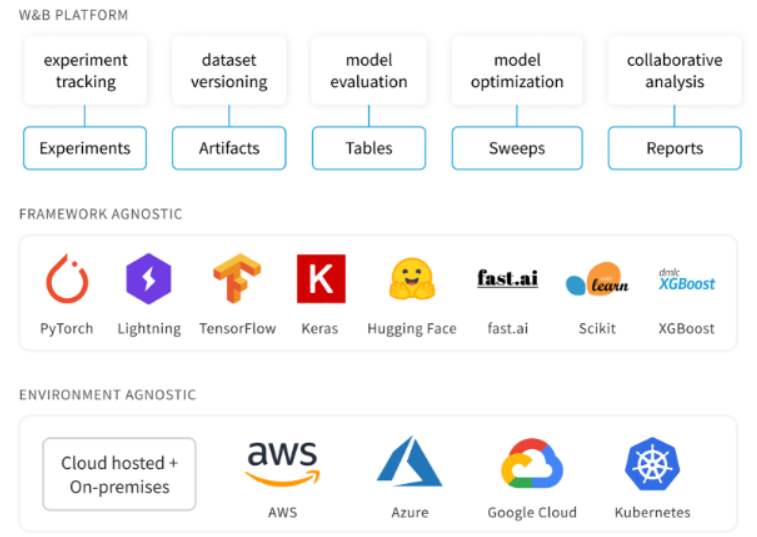

#### [가입](https://wandb.ai/site)

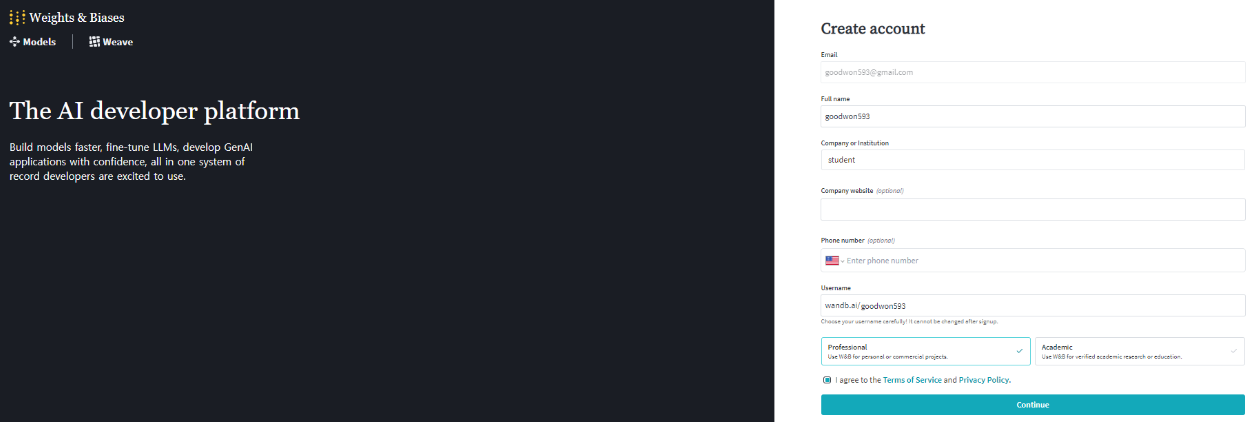

#### [토큰 생성](https://wandb.ai/authorize)

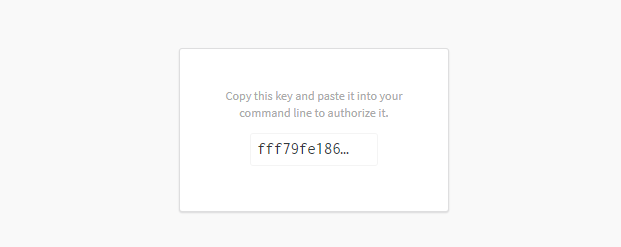

### SFTConfig with W&B

In [11]:
from transformers import TrainingArguments

args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4, # learning rate
        # optim = "adamw_8bit", # 옵티마이저
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407, # ramdom seed 고정
        output_dir = "outputs",
        # W&B -> 로깅 설정
        report_to="wandb",  # W&B로 로깅 활성화
        run_name="alpaca-base-high-lr",  # W&B 실행 이름 (선택사항)
        logging_steps=1,  # W&B에 얼마나 자주 로그를 남길지
    )

### SFTTrainer

In [18]:
trainer = SFTTrainer(
    model,
    train_dataset=dataset,
    args=args,
    peft_config=peft_config,
    formatting_func=formatting_prompts_func,
    data_collator=collator
)

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:543: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/7040 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/7040 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/7040 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/7040 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/7040 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [19]:
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: goodwon593 (goodwon593-student-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
1,1.102700
2,1.125800
3,0.964400
4,1.015700
5,1.074100
6,0.906500
7,0.790800
8,0.904000
9,0.974700
10,0.788000


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


TrainOutput(global_step=60, training_loss=0.8244485904773077, metrics={'train_runtime': 614.9478, 'train_samples_per_second': 0.781, 'train_steps_per_second': 0.098, 'total_flos': 5657811217459200.0, 'train_loss': 0.8244485904773077})

### [W&B - 로그 확인](https://wandb.ai/goodwon593-student-/huggingface/runs/71lqolvh?nw=nwusergoodwon593)

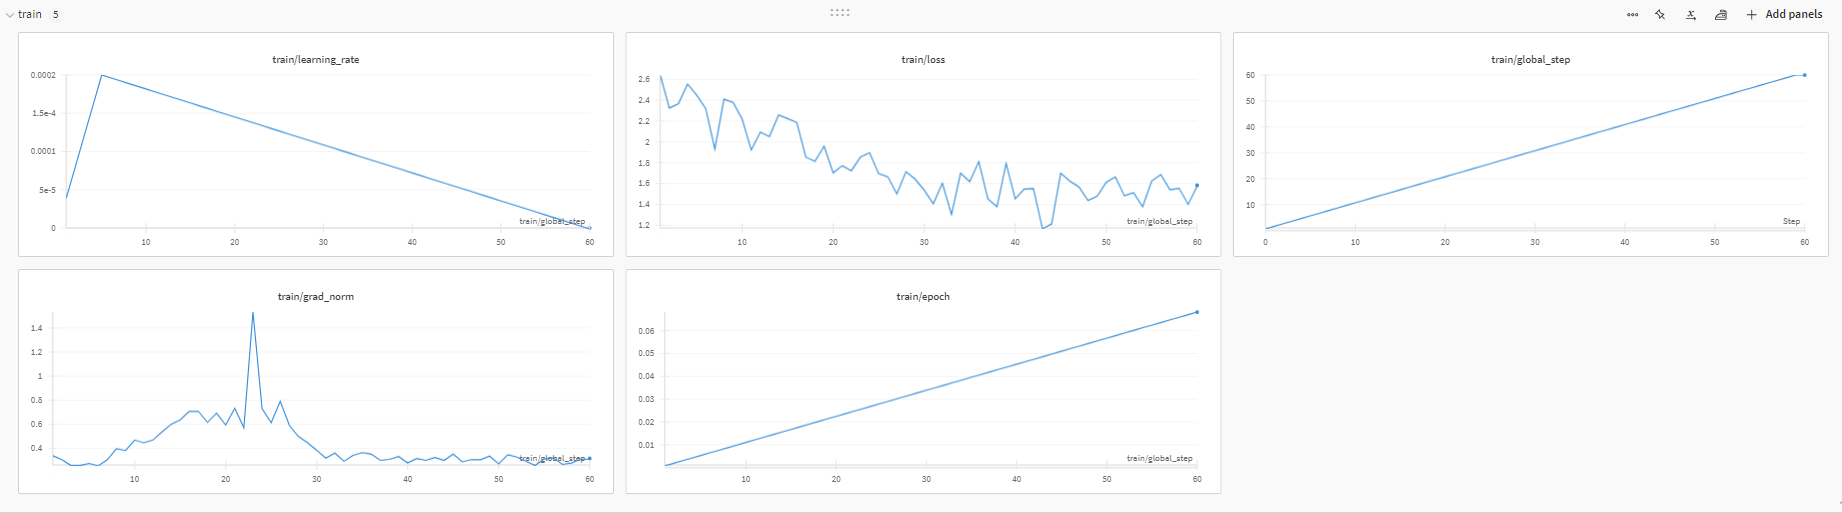

## Inference

In [20]:
from transformers import pipeline

In [21]:
pipe = pipeline(
    task='text-generation', # 문장을 생성하는 업무
    model=model,
    tokenizer=tokenizer,
    device=0 # GPU
)

Device set to use cuda:0


In [22]:
def ask(x, context='', is_input_full=False):
    ans = pipe(
        f"### 질문: {x}\n\n### 맥락: {context}\n\n### 답변:" if context else f"### 질문: {x}\n\n### 답변:",
        do_sample=True,
        max_new_tokens=512,
        temperature=0.7,
        top_p=0.9,
        return_full_text=False,
        eos_token_id=tokenizer.eos_token_id
    )
    print(ans[0]['generated_text'])

In [23]:
ask("딥러닝이 뭐야?")

 딥러닝은 머신 러닝의 한 분야로, 인공 신경망을 사용하여 데이터에서 패턴을 학습하고 예측을 수행하는 알고리즘을 말합니다. 딥러닝은 복잡한 문제를 해결하기 위해 여러 층으로 구성된 신경망을 사용하며, 이는 인간의 뇌를 모방한 것으로 볼 수 있습니다. 각 층은 입력 데이터를 처리하고 다음 층으로 전달하며, 이 과정을 통해 최종적으로 예측을 수행합니다. 딥러닝은 이미지 인식, 자연어 처리, 음성 인식, 의료 진단 등 다양한 분야에서 활용되고 있습니다.
